<a href="https://colab.research.google.com/github/KarimElAtbany/Covid-19-Detection-by-Deep-learning/blob/main/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"karimnabel","key":"f21ada9fa9499d67d1d0db1f5f1df91b"}'}

connect our lab to drive


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os 
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/Colab Notebooks'

In [ ]:
%cd covid-19-xray-and-ct-scan-image-dataset.zip

[Errno 2] No such file or directory: 'covid-19-xray-and-ct-scan-image-dataset.zip'
/content


In [ ]:
pip install split-folders

In [ ]:
pip install split-folders[full]

In [ ]:
pip install chart-studio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


import laibraies that will we use


In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import glob as gb
import tensorflow as tf
import keras 
import cv2
import sklearn.metrics as metrics
from tqdm.auto import tqdm
import pickle
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.applications.densenet import preprocess_input as preprocess_input_densenet
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling2D, Dropout
from keras.models import Model
from tensorflow.keras.optimizers import Adam
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot
import tensorflow_hub as hub
from keras.models import load_model
from keras.preprocessing import image


get pathes of train and valid
Dataset is organized into 2 folders (train, validation) and both contain 2 subfolders (COVID19,NORMAL) one for each class. DataSet contains x-ray images and test data have 20% of total images. As a start, it is very important to inspect the data across the two
 classes:

In [ ]:
#get pathes for train 
tr_covid='/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train/COVID'
tr_non_covid='/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train/Non-COVID'
#get pathes for valid
val_covid='/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val/COVID'
val_non_covid='/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val/Non-COVID'

In [ ]:
print(f'the number of images in train covid is {len(os.listdir(tr_covid))} \nthe number of train non covid is {len(os.listdir(tr_non_covid))}')
print(f'the number of images in valid covid is {len(os.listdir(val_covid))} \nthe number of valid non covid is {len(os.listdir(val_non_covid))}')

the number of images in train covid is 2817 
the number of train non covid is 3679
the number of images in valid covid is 805 
the number of valid non covid is 1051


In [ ]:
tr=len(os.listdir(tr_covid))+len(os.listdir(tr_non_covid))
val=len(os.listdir(val_covid))+len(os.listdir(val_non_covid))
print(tr,val)

6496 1856


In [ ]:
all_normal=len(os.listdir(tr_covid))+len(os.listdir(val_covid))
print(all_normal)
all_pneumonia=len(os.listdir(tr_non_covid))+len(os.listdir(val_non_covid))
print(all_pneumonia)



3622
4730


In [ ]:
labels = ["Normal",'Pneumonia ']
values = [(all_normal),(all_pneumonia)]
colors = ['sky', 'red']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Image Category Distribution",
                  titlefont={'size': 30},      
                  )
iplot(fig)

In [ ]:
labels = ["Train",'Test ']
values = [(80),(20)]
colors = ['green', 'sky']
fig = go.Figure(data=[go.Pie(labels=labels,
                             values=values,hole=.5)])
fig.update_traces(hoverinfo='value', textinfo='label+percent', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=3)))
fig.update_layout(title="Data Split",
                  titlefont={'size': 30},      
                  )
iplot(fig)

read the data set images with different extenstions and resize it and append it to array

In [ ]:
#read images for tr_covid 
s=244
train=[]

ext=['png','jpeg','jpg']

for e in ext :
  files = gb.glob(pathname= str('/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train/COVID/*.'+e))
  for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    train.append(list(image_array))
  print(e)


png
jpeg
jpg


In [ ]:
x=np.array(train)
print(x.shape)

(2817, 244, 244, 3)


In [ ]:
#read  images for tr_non_covid 
s=244
train_n=[]

ext=['png','jpeg','jpg']

for e in ext :
  files = gb.glob(pathname= str('/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train/Non-COVID/*.'+e))
  for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    train_n.append(list(image_array))
  print(e)


png
jpeg
jpg


In [ ]:
x1=np.array(train_n)
print(x1.shape)

(3675, 244, 244, 3)


In [ ]:
labels = np.concatenate((np.repeat('COVID',len(os.listdir(tr_covid))),np.repeat('non_covid',len(os.listdir(tr_non_covid)))))
image_files = np.concatenate((os.listdir(tr_covid),os.listdir(tr_non_covid)))
df = pd.DataFrame({'image_id':image_files,'class_id':labels})
df.head()


,image_id,class_id
0,person1488_virus_2592.jpeg,COVID
1,person1363_virus_2346.jpeg,COVID
2,person1376_virus_2367.jpeg,COVID
3,person1452_virus_2484.jpeg,COVID
4,person143_virus_289.jpeg,COVID


In [ ]:
#read  images for valid_covid 
s=244
valid=[]

ext=['png','jpeg','jpg']

for e in ext :
  files = gb.glob(pathname= str('/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val/COVID/*.'+e))
  for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    valid.append(list(image_array))
  print(e)


png
jpeg
jpg


In [ ]:
v=np.array(valid)
print(v.shape)

(804, 244, 244, 3)


In [ ]:
#read  images for valid_non_covid 
s=244
valid_n=[]

ext=['png','jpeg','jpg']

for e in ext :
  files = gb.glob(pathname= str('/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val/Non-COVID/*.'+e))
  for file in files: 
    image = cv2.imread(file)
    image_array = cv2.resize(image , (s,s))
    valid_n.append(list(image_array))
  print(e)


png
jpeg
jpg


In [ ]:
v1=np.array(valid_n)
print(v1.shape)

(1048, 244, 244, 3)


In [ ]:
labels = np.concatenate((np.repeat('COVID',len(os.listdir(val_covid))),np.repeat('non_covid',len(os.listdir(val_non_covid)))))
image_files = np.concatenate((os.listdir(val_covid),os.listdir(val_non_covid)))
df = pd.DataFrame({'image_id':image_files,'class_id':labels})
df.head()


,image_id,class_id
0,21982772.png,COVID
1,5359825d.png,COVID
2,41591_2020_819_Fig1_HTML.webp-day10.png,COVID
3,80446565-E090-4187-A031-9D3CEAA586C8.jpeg,COVID
4,COVID-19 (106).jpg,COVID


**Data scaling, normalization and augmentation**
Based on data inspection, images are scaled to a size of 244 by 244, normalized to values (0,1) and augmented by simple zoom and rotation to enhance the generalization.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
def process_data(batch_size = 32, image_dim = 224):
    train_gen = ImageDataGenerator(rescale=1/256, rotation_range = 0.05,shear_range = 0.05, zoom_range=0.05,vertical_flip=True, horizontal_flip=True)
    validation_gen = ImageDataGenerator(rescale = 1/256)
    
    train_gen = train_gen.flow_from_directory(
    directory = '/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train',
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    target_size = (image_dim,image_dim)
    )
    
    validation_gen = validation_gen.flow_from_directory(
    directory = '/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val',
    batch_size = batch_size,
    class_mode = 'binary',
    shuffle = True,
    target_size = (image_dim,image_dim)
    )
    
    return train_gen, validation_gen
vgg_train_gen = process_data()
vgg_validation_gen = process_data()

Found 6492 images belonging to 2 classes.
Found 1853 images belonging to 2 classes.
Found 6492 images belonging to 2 classes.
Found 1853 images belonging to 2 classes.


In [ ]:
image_generator1 = ImageDataGenerator(rescale=1/256, preprocessing_function=None, horizontal_flip=False)
image_generator2 = ImageDataGenerator(rescale=1/256, preprocessing_function = None)


train_gen = image_generator1.flow_from_directory(batch_size=32,
                                                    directory=r'/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/train',
                                                    shuffle=True,
                                                    target_size=(512, 512),
                                                    class_mode='binary')

validation_gen = image_generator2.flow_from_directory(batch_size=32,
                                                   directory=r'/content/gdrive/MyDrive/Colab Notebooks/COVID-19 Dataset/pr/val',
                                                   shuffle=True,
                                                   target_size=(512, 512),
                                                   class_mode='binary')

Found 6492 images belonging to 2 classes.
Found 1853 images belonging to 2 classes.


In [ ]:
METRICS = [
        'accuracy',
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]

In [ ]:
URL = r'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'

feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))
feature_extractor.trainable = False

linear_model = model = tf.keras.models.Sequential([    
    feature_extractor,
    tf.keras.layers.Dense(1, activation='linear'), 
    tf.keras.layers.Dense(1,activation='sigmoid')])
linear_model.compile(Adam(lr=.001), loss = 'binary_crossentropy', metrics =[METRICS])
linear_model.summary()

In [ ]:
linear_checkpoint_callback = ModelCheckpoint('linear_model_augs.h5', monitor='val_accuracy', verbose = True, save_best_only = True, save_weights_only = False, mode= 'max')
linear_early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

with tf.device('/GPU:0'):
    linear_fit = linear_model.fit_generator(generator=train_gen,
                              validation_data=validation_gen,
                              steps_per_epoch= (train_gen.samples // 32),
                              validation_steps = (validation_gen.samples // 32),
                              use_multiprocessing=True,
                              workers=-1,
                              verbose = True,
                              epochs = 20,
                              callbacks = [linear_checkpoint_callback, linear_early_stopping_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
202/202 [==============================] - ETA: 0s - loss: 0.3894 - accuracy: 0.8331 - precision: 0.8440 - recall: 0.8656
Epoch 1: val_accuracy improved from -inf to 0.89583, saving model to linear_model_augs.h5
202/202 [==============================] - 459s 2s/step - loss: 0.3894 - accuracy: 0.8331 - precision: 0.8440 - recall: 0.8656 - val_loss: 0.2849 - val_accuracy: 0.8958 - val_precision: 0.9086 - val_recall: 0.9069
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 0.2609 - accuracy: 0.8991 - precision: 0.9210 - recall: 0.8989
Epoch 2: val_accuracy improved from 0.89583 to 0.91283, saving model to linear_model_augs.h5
202/202 [==============================] - 433s 2s/step - loss: 0.2609 - accuracy: 0.8991 - precision: 0.9210 - recall: 0.8989 - val_loss: 0.2377 - val_accuracy: 0.9128 - val_precision: 0.9340 - val_recall: 0.9094
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9200 - precision: 0.9355 - recal

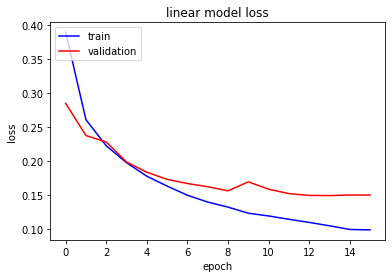

In [ ]:
plt.plot(np.array(linear_fit.history['loss']),color='blue')
plt.plot(np.array(linear_fit.history['val_loss']),color='red')
plt.title('linear model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

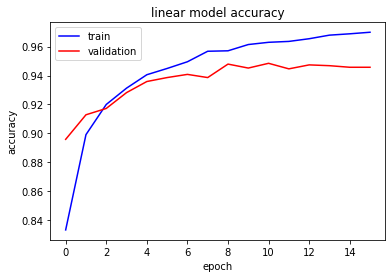

In [ ]:
plt.plot(np.array(linear_fit.history['accuracy']),color='blue')
plt.plot(np.array(linear_fit.history['val_accuracy']),color='red')
plt.title('linear model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
URL = r'https://tfhub.dev/google/imagenet/resnet_v2_152/feature_vector/4'

feature_extractor = hub.KerasLayer(URL, input_shape=(224,224,3))
feature_extractor.trainable = False

deep_model = tf.keras.models.Sequential([    
    feature_extractor,
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(8, activation='relu'),
    tf.keras.layers.Dense(1,activation='sigmoid')    
])
deep_model.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=METRICS )
deep_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 2048)              58331648  
                                                                 
 dense (Dense)               (None, 64)                131136    
                                                                 
 dense_1 (Dense)             (None, 16)                1040      
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 58,463,969
Trainable params: 132,321
Non-trainable params: 58,331,648
_________________________________________________________________


In [ ]:
deep_checkpoint_callback = ModelCheckpoint('ResNet152_model_augs.h5', monitor='val_accuracy', verbose = True, save_best_only = True, save_weights_only = False, mode= 'max')
deep_early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=5)

with tf.device('/GPU:0'):
    deep_fit = linear_model.fit_generator(generator=train_gen,
                              validation_data=validation_gen,
                              steps_per_epoch= (train_gen.samples // 32),
                              validation_steps = (validation_gen.samples // 32),
                              use_multiprocessing=True,
                              workers=-1,
                              verbose = True,
                              epochs = 20,
                              callbacks = [deep_checkpoint_callback, deep_early_stopping_callback])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:13: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  del sys.path[0]


Epoch 1/20
202/202 [==============================] - ETA: 0s - loss: 0.3971 - accuracy: 0.8362 - precision: 0.8406 - recall: 0.8769
Epoch 1: val_accuracy improved from -inf to 0.89035, saving model to ResNet152_model_augs.h5
202/202 [==============================] - 488s 2s/step - loss: 0.3971 - accuracy: 0.8362 - precision: 0.8406 - recall: 0.8769 - val_loss: 0.2980 - val_accuracy: 0.8904 - val_precision: 0.9030 - val_recall: 0.9030
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 0.2735 - accuracy: 0.8893 - precision: 0.9133 - recall: 0.8891
Epoch 2: val_accuracy improved from 0.89035 to 0.90406, saving model to ResNet152_model_augs.h5
202/202 [==============================] - 456s 2s/step - loss: 0.2735 - accuracy: 0.8893 - precision: 0.9133 - recall: 0.8891 - val_loss: 0.2496 - val_accuracy: 0.9041 - val_precision: 0.9113 - val_recall: 0.9193
Epoch 3/20
202/202 [==============================] - ETA: 0s - loss: 0.2320 - accuracy: 0.9144 - precision: 0.9311 -

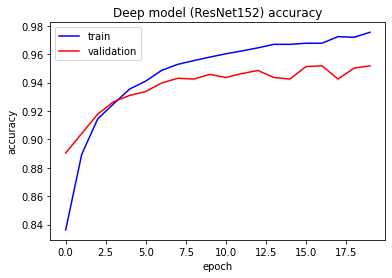

In [ ]:
plt.plot(np.array(deep_fit.history['accuracy']),color='blue')
plt.plot(np.array(deep_fit.history['val_accuracy']),color='red')
plt.title('Deep model (ResNet152) accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

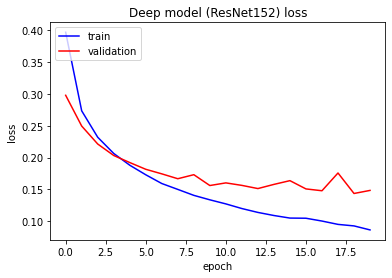

In [ ]:
plt.plot(np.array(deep_fit.history['loss']),color='blue')
plt.plot(np.array(deep_fit.history['val_loss']),color='red')
plt.title('Deep model (ResNet152) loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model=load_model('/content/gdrive/MyDrive/Colab Notebooks/model /ResNet152_model_augs.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
image_path='/content/43055_2020_296_Fig11_HTML.png'
test_image = image.load_img(image_path,target_size=(244,244))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

result = model.predict(test_image)
print(result)
if result[0][0]==1:
  prediction='covid'
  print(prediction)
else:
  prediction='non_covid'
  print(prediction)



[[1.]]
covid


In [ ]:
image_path=input('enter the path of chest')
test_image = image.load_img(image_path,target_size=(244,244))
test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis=0)

result = model.predict(test_image)
print(result)

if result[0][0]==1:
  prediction='covid'
  print(prediction)
else:
  prediction='non_covid'
  print(prediction)

plt.imshow(test_image)
plt.axis('on')
plt.title(prediction)



In [ ]:
# retrieve:    
f = open('/content/gdrive/MyDrive/Colab Notebooks/model /ResNet152_model_augs_history.pickle', 'rb')
history = pickle.load(f)
f.close()